In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="rgb_array")
observation, info = env.reset()

In [3]:
env.action_space

Discrete(4)

In [4]:
env.observation_space

Discrete(64)

In [5]:
n_actions = env.action_space.n
n_states = env.observation_space.n

In [6]:
def render():
    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

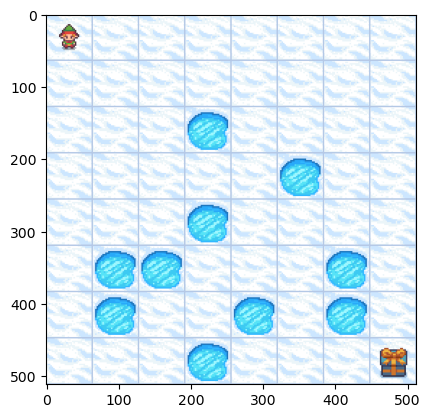

In [7]:
render()

In [8]:
env.unwrapped.desc

array([[b'S', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'H', b'H', b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'H', b'F', b'H', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'G']], dtype='|S1')

In [9]:
chr(env.unwrapped.desc[0][0][0])

'S'

In [10]:
# To get the list of terminated states so as to remove them from the policy or Q as starting states.
ignore_list = []
for i in range(len(env.unwrapped.desc)):
    for j in range(len(env.unwrapped.desc[0])):
        if(chr(env.unwrapped.desc[i][j][0]) != 'F' and chr(env.unwrapped.desc[i][j][0]) != 'S'):
            print(i, j)
            ignore_list.append(8*i + j)

2 3
3 5
4 3
5 1
5 2
5 6
6 1
6 4
6 6
7 3
7 7


In [11]:
ignore_list

[19, 29, 35, 41, 42, 46, 49, 52, 54, 59, 63]

In [12]:
# A policy will be a state-action pair dictionary, which will dictate what action to take when youre in a given state.
# We will initialize our policy with random values for the sake of it.
# Policy contains actions for terminate states as well, we will ignore those in the future 
# policy = {state:env.action_space.sample() for state in range(n_states)}

In [13]:
# Q is an action-value pair dictionary, which dictates what is the total reward which my action will lead to if the policy is followed
# Q = {state: (action, compute_state_values(state, action)) for state in states for action in range(n_actions)} 

In [14]:
# We are going to use Any-Visit Monte Carlo
# So we will have 1 global Q table and another table to keep count of the number of times an action on a given state has been performed
Q_mc = np.zeros((n_states, n_actions))
rewards = np.zeros((n_states, n_actions))
visits = np.zeros((n_states, n_actions))
n_episodes = 10000

In [15]:
# To update rewards and visits accordingly
def update(state, action, reward):
    rewards[state][action] += reward
    visits[state][action] += 1

In [16]:
def run_episodes_monte_carlo(n_episodes):
    for _ in range(n_episodes):
        observation, info = env.reset()
        state = observation
    
        # Run the episode till termination
        while True:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)     
            # To prevent wastage of time in executing actions which land agent on same block as they cant be executed
            if state == next_state:
                continue
            update(state, action, reward)
            state = next_state
            if (terminated or truncated): 
                break

# Update the Q_mc table after termination
def update_q_table_monte_carlo():
    for state in range(n_states):
        for action in range(n_actions):
            if visits[state][action] >= 1:
                Q_mc[state][action] =  rewards[state][action] / visits[state][action]

In [17]:
def rewards_result(Q):
    for i in range(n_states):
        for j in range(n_actions):
            if Q[i][j] > 0:
                print(f"state {i} and action {j} has a reward of {Q[i][j]}")

In [18]:
run_episodes_monte_carlo(n_episodes)
update_q_table_monte_carlo()
rewards_result(Q_mc)

state 55 and action 1 has a reward of 1.0


In [19]:
# We are now going to implement SARSA
gamma = 0.9
alpha = 0.4
Q_sarsa = np.zeros((n_states, n_actions))

def update_q_table_sarsa(state, action, next_state, next_action, reward):
    old_value = Q_sarsa[state][action]
    new_value = Q_sarsa[next_state][next_action]

    Q_sarsa[state][action] = ((1-alpha) * old_value) + (alpha * (reward + gamma * new_value))

def run_episodes_sarsa(n_episodes):
    for _ in range(n_episodes):
        state, info = env.reset()
        action = env.action_space.sample()
        
        # Run the episode till termination
        while True:
            next_state, reward, terminated, truncated, info = env.step(action)
            # To prevent an episode from staying in one state infinitely as invalid actions are not classified as terminated or truncated
            if state == next_state:
                action = env.action_space.sample()
                continue
            next_action = env.action_space.sample()
            update_q_table_sarsa(state, action, next_state, next_action, reward)
            state, action = next_state, next_action
            if (terminated or truncated): 
                break

In [20]:
run_episodes_sarsa(n_episodes)
rewards_result(Q_sarsa)

state 0 and action 1 has a reward of 3.6629532598130675e-07
state 0 and action 2 has a reward of 2.050209002192134e-05
state 1 and action 0 has a reward of 6.357432111729859e-07
state 1 and action 1 has a reward of 5.878347052621913e-06
state 1 and action 2 has a reward of 6.599543566732598e-05
state 2 and action 0 has a reward of 6.03467706807747e-06
state 2 and action 1 has a reward of 2.408084153657608e-05
state 2 and action 2 has a reward of 7.508318721683248e-05
state 3 and action 0 has a reward of 5.708294411937818e-05
state 3 and action 1 has a reward of 3.0372370494720047e-05
state 3 and action 2 has a reward of 0.00011610601042112606
state 4 and action 0 has a reward of 8.018993639438601e-05
state 4 and action 1 has a reward of 0.0001965224355531561
state 4 and action 2 has a reward of 0.000441678704813579
state 5 and action 0 has a reward of 0.00018808619934508684
state 5 and action 1 has a reward of 0.0006063184153957083
state 5 and action 2 has a reward of 0.000585922451189

In [21]:
# Policy will be {state:action} pair
def compute_policy(Q):
    policy = {}
    for state in range(n_states):
        # Find the action with the highest Q-value for each state
        best_action = max(range(n_actions), key=lambda action: Q[state][action])
        policy[state] = best_action
    return policy

In [43]:
def compute_state_value(policy, state):
    total_reward = 0
    env.unwrapped.s = state
    while True:
        if state in ignore_list:
            break
        action = policy[state]
        print(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        print(next_state, reward, terminated, truncated, info)
        total_reward += reward
        if terminated or truncated:
            return total_reward
        if state == next_state:
            return 0
        state = next_state

In [45]:
def policy_evaluation(policy):
    V = {state: compute_state_value(policy, state) for state in range(n_states)}
    return V

In [46]:
def no_path(V):
    count = 0
    for i in range(n_states):
        if V[i] == 0:
            count += 1
    return count

In [25]:
# # Policy evaluation for a stochastic environment is done by taking the avg of rewards across multiple episodes 
# reward_per_learned_episode = []
# for episode in range(10000):
#     state, info = env.reset()
#     terminated = False
#     episode_reward = 0
#     while not (terminated or truncated):
#         action = policy[state]
#         new_state, reward, terminated, truncated, info = env.step(action)
#         state = new_state
#         episode_reward += reward
#     reward_per_learned_episode.append(episode_reward)

# avg_reward_per_learned_episode = np.mean(reward_per_learned_episode)
# print("Average reward per learned episode: ", avg_reward_per_learned_episode)

In [26]:
# Time to implement epsilon-greedy function now...

In [27]:
Q_greedy = np.zeros((n_states, n_actions))

In [28]:
epsilon = 0.8
min_epsilon = 0.3
decay = 0.9
def get_action(state):
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q_greedy[state])
    return action

In [29]:
def update_q_table_greedy(state, action, next_state, next_action, reward): # Using sarsa ofcourse
    old_value = Q_greedy[state][action]
    new_value = Q_greedy[next_state][next_action]

    Q_greedy[state][action] = ((1-alpha) * old_value) + (alpha * (reward + gamma * new_value))

In [30]:
def run_episodes_greedy(n_episodes):
    global epsilon
    for _ in range(n_episodes):
        state, info = env.reset()
        action = random.choice([1, 2])
        prev_action = None
        while True:
            _, next_state, reward, _ = env.unwrapped.P[state][action][0]
            next_action = get_action(next_state)
            while next_action == prev_action:
                next_action = get_action(next_state)
            _, next_next_state, next_reward, truncated = env.unwrapped.P[next_state][next_action][0]
            if truncated:
                if next_reward != 1:
                    continue
                else:
                    update_q_table_greedy(state, action, next_state, next_action, reward)
                    update_q_table_greedy(next_state, next_action, next_next_state, env.action_space.sample(), next_reward)
                    break                   
            if next_state == next_next_state:
                prev_action = next_action
                continue
            next_state, reward, terminated, truncated, _ = env.step(action)
            update_q_table_greedy(state, action, next_state, next_action, reward)
            if terminated or truncated:
                break
            state, action = next_state, next_action
        epsilon = max(min_epsilon, epsilon * decay)

In [31]:
run_episodes_greedy(n_episodes)
rewards_result(Q_greedy)

state 0 and action 1 has a reward of 0.14024560342620201
state 0 and action 2 has a reward of 0.17862596700764377
state 1 and action 0 has a reward of 0.1346130144656801
state 1 and action 1 has a reward of 0.1613694137479671
state 1 and action 2 has a reward of 0.20756218542917806
state 2 and action 0 has a reward of 0.15881810829275292
state 2 and action 1 has a reward of 0.18127868085161983
state 2 and action 2 has a reward of 0.2300564060719941
state 3 and action 0 has a reward of 0.16285226675338654
state 3 and action 1 has a reward of 0.19361714751430065
state 3 and action 2 has a reward of 0.25043323411691387
state 4 and action 0 has a reward of 0.18901566994689006
state 4 and action 1 has a reward of 0.23934826024461037
state 4 and action 2 has a reward of 0.26707655135333364
state 5 and action 0 has a reward of 0.2360809688050856
state 5 and action 1 has a reward of 0.2959534606381536
state 5 and action 2 has a reward of 0.3003879906055612
state 6 and action 0 has a reward of 

In [47]:
policy_mc = compute_policy(Q_mc)
policy_sarsa = compute_policy(Q_sarsa)
policy_greedy = compute_policy(Q_greedy)

In [48]:
V_mc = policy_evaluation(policy_mc)
V_sarsa = policy_evaluation(policy_sarsa)
V_greedy = policy_evaluation(policy_greedy)

0
0 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
1 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
2 0.0 False False {'prob': 1.0}
0
1 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
3 0.0 False False {'prob': 1.0}
0
2 0.0 False False {'prob': 1.0}
0
1 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
4 0.0 False False {'prob': 1.0}
0
3 0.0 False False {'prob': 1.0}
0
2 0.0 False False {'prob': 1.0}
0
1 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
5 0.0 False False {'prob': 1.0}
0
4 0.0 False False {'prob': 1.0}
0
3 0.0 False False {'prob': 1.0}
0
2 0.0 False False {'prob': 1.0}
0
1 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
0 0.0 False False {'prob': 1.0}
0
6 0.0 False False {'prob': 1.0}
0
5 0.0 False 

In [34]:
no_path_mc = no_path(V_mc)
no_path_sarsa = no_path(V_sarsa)
no_path_greedy = no_path(V_greedy)
print(f"Total number of states you can start from is {n_states - len(ignore_list)} ")
print(f"Number of states in Monte-Carlo from which a path doesnt exist: {no_path_mc}")
print(f"Number of states in SARSA from which a path doesnt exist: {no_path_sarsa} ")
print(f"Number of states in GREEDY from which a path doesnt exist: {no_path_greedy} ")

Total number of states you can start from is 53 
Number of states in Monte-Carlo from which a path doesnt exist: 52
Number of states in SARSA from which a path doesnt exist: 51 
Number of states in GREEDY from which a path doesnt exist: 51 


In [35]:
V_greedy

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: None,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: None,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: None,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: None,
 42: None,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: None,
 47: 0.0,
 48: 0.0,
 49: None,
 50: 0.0,
 51: 0.0,
 52: None,
 53: 0.0,
 54: None,
 55: 1.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: None,
 60: 0.0,
 61: 0.0,
 62: 1.0,
 63: None}

In [36]:
def render_policy_execution(env, policy):
    state, info = env.reset()
    terminated, truncated = False, False
    total_reward = 0
    steps = 0

    while not (terminated or truncated):
        render()
        print(policy[state])
        action = policy[state]
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1

    print(f"Total reward: {total_reward} in {steps} steps")

In [37]:
# render_policy_execution(env, policy_mc)

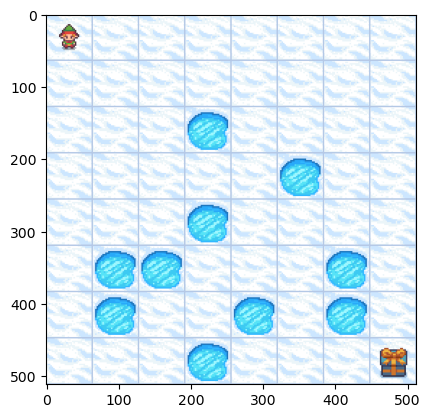

2


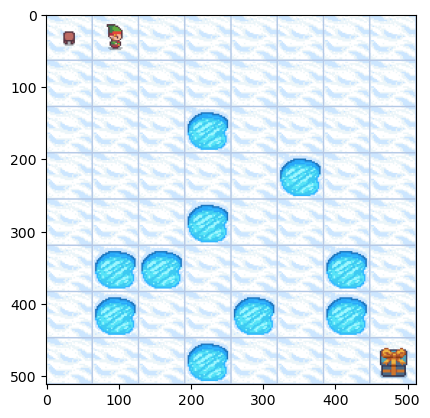

2


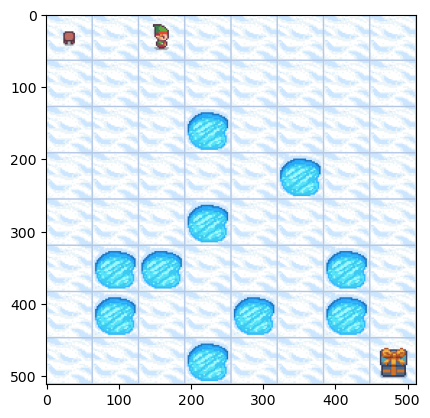

2


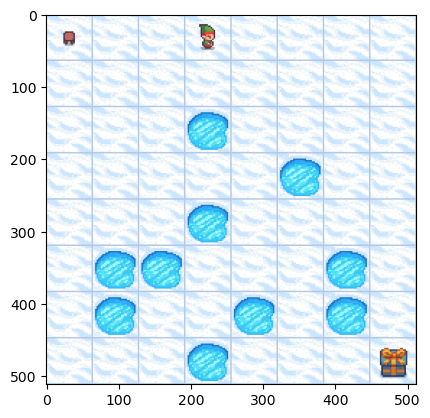

2


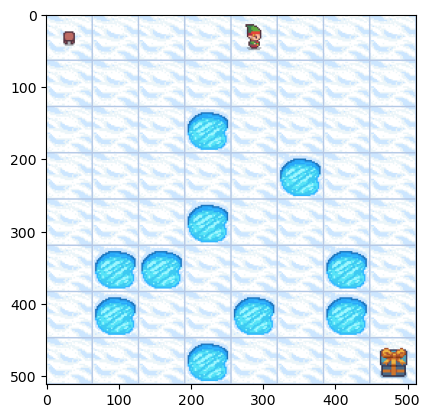

2


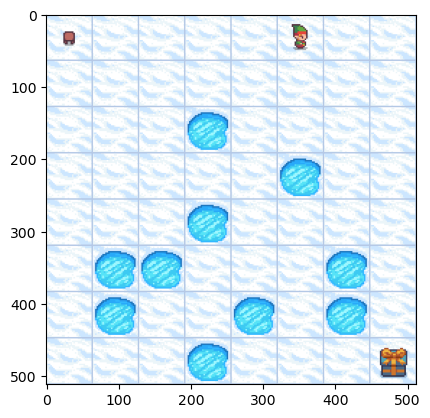

1


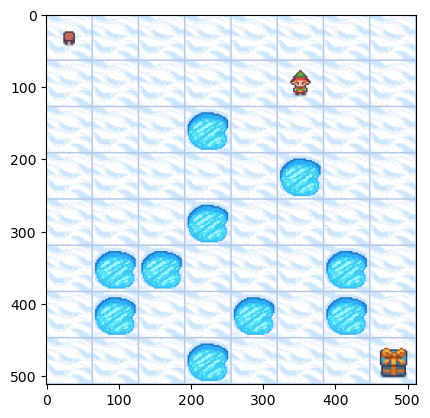

1


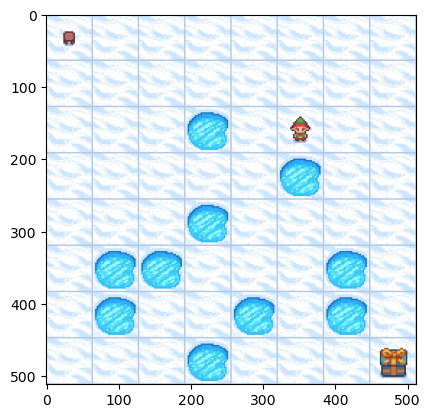

2


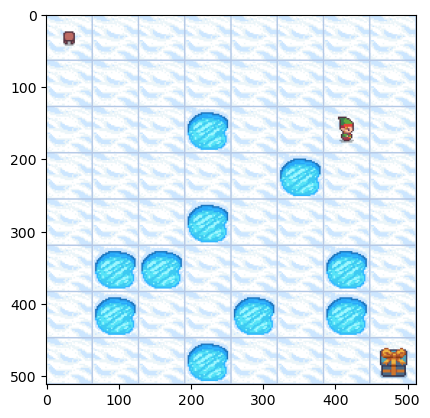

1


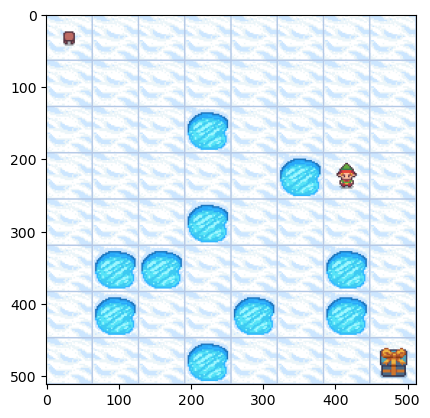

2


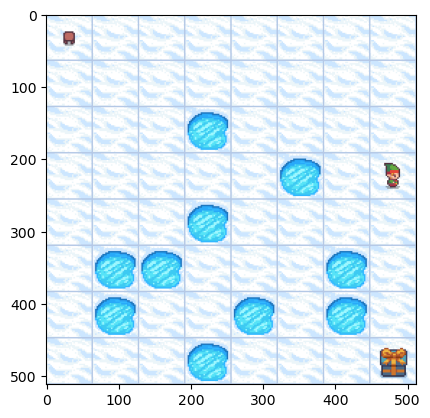

1


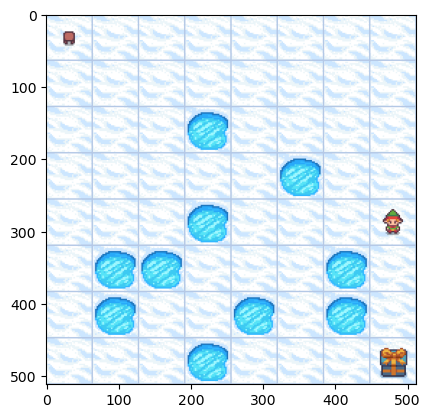

1


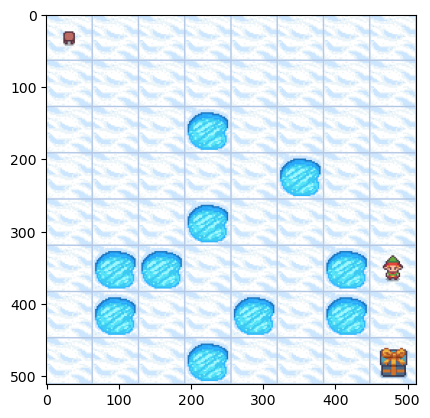

1


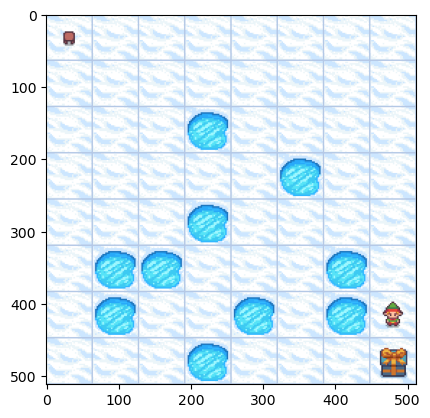

1
Total reward: 1.0 in 14 steps


In [38]:
render_policy_execution(env, policy_sarsa)

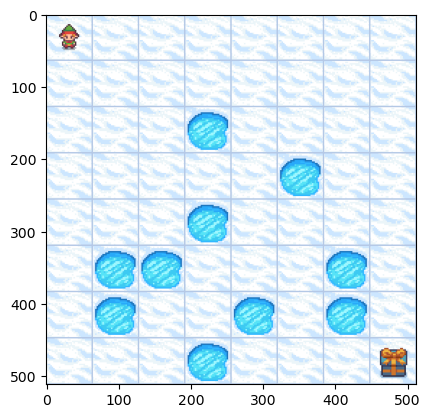

2


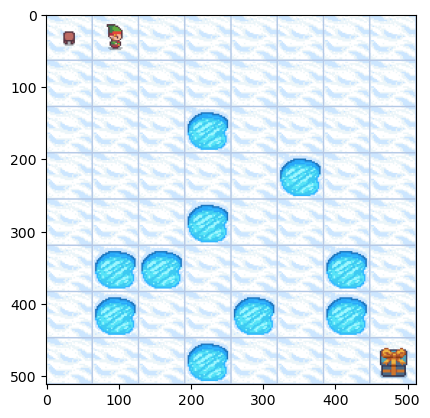

2


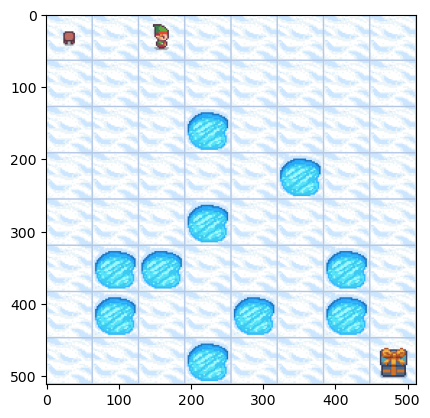

2


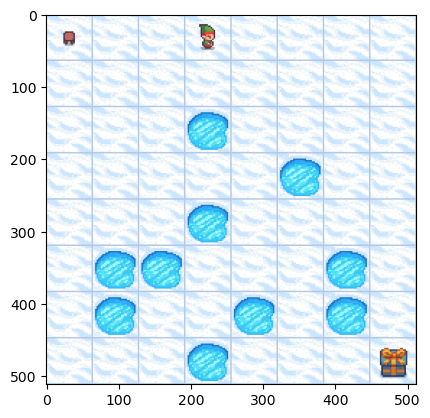

2


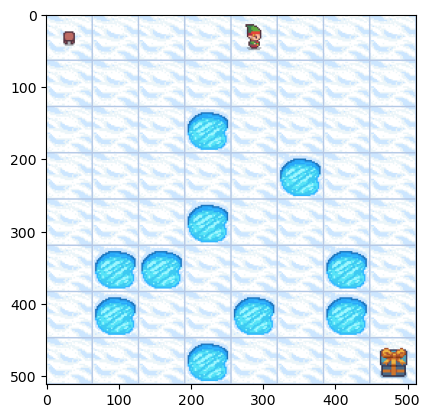

2


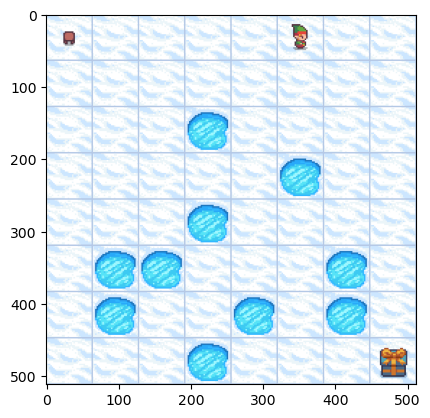

2


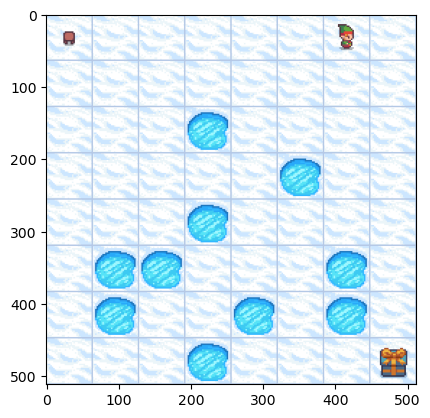

2


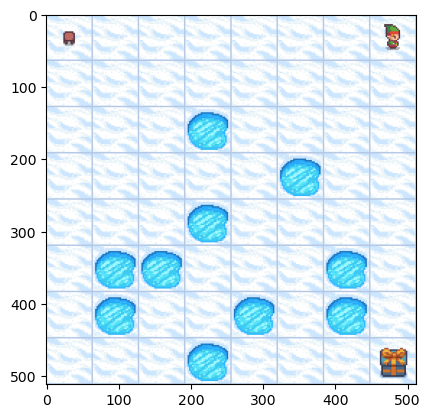

1


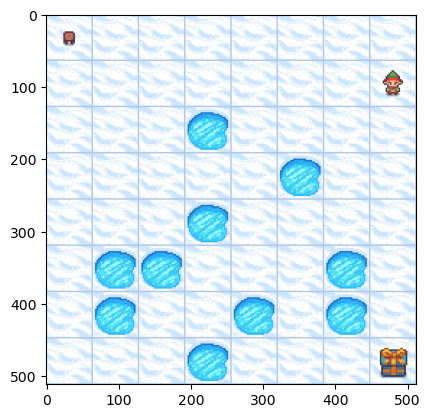

1


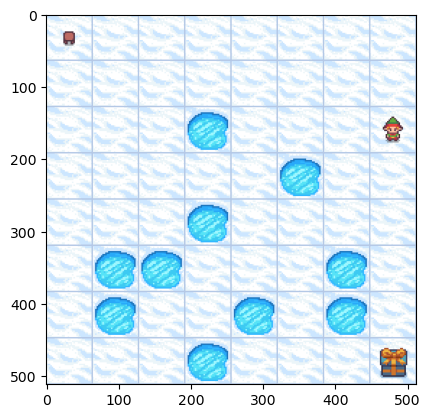

1


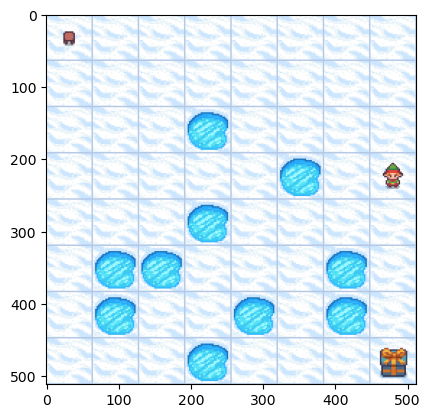

1


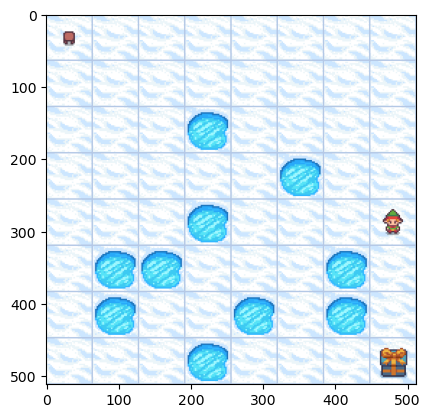

1


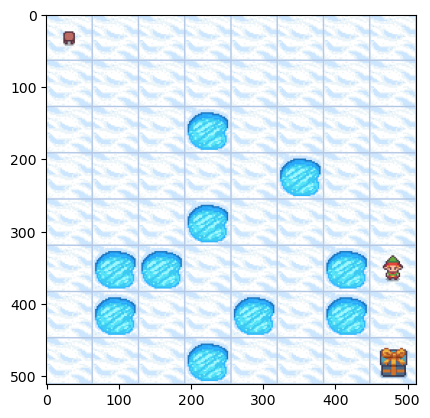

1


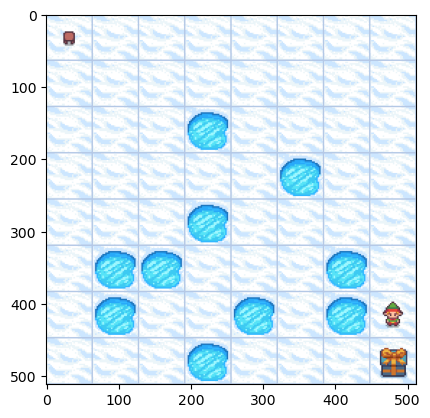

1
Total reward: 1.0 in 14 steps


In [39]:
render_policy_execution(env, policy_greedy)